# Lezione 10

## Dario Pullia

### Esercizio 10.1

Spiegazioni varie

Figo come ho riempito i randompath

Superfiga la struttura dati

Flexino su quanto efficiente è il tutto

Flexone sul saper risolvere il problema con 300 punti in meno di 6 secondi

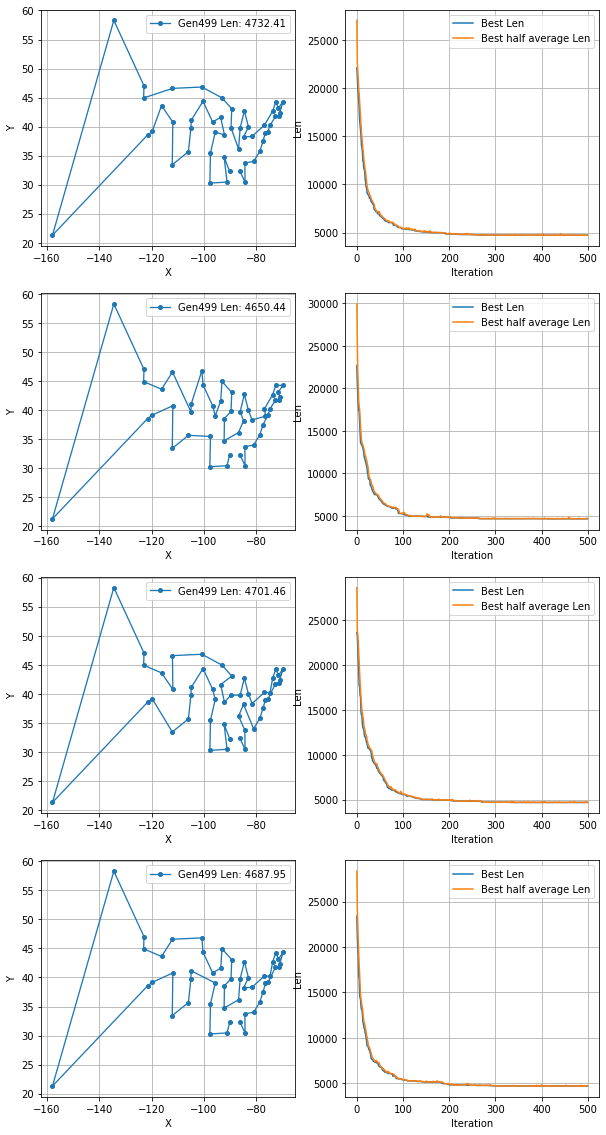

In [49]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
import imageio


C=0
X,Y = np.loadtxt("data01/American_capitals/Region.dat",  usecols=(0,1), delimiter=' ', unpack='true')

filenames=[]
N=(X.size)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(10, 20))
fig.suptitle('')
    
Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data01/American_capitals/0/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/American_capitals/0/Bests.dat",)
M=len(Best)-1

for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax1.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid(True)
ax1.legend()


ax2.plot(np.arange(M+1), Len,label='Best Len')
ax2.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Len')
ax2.grid(True)
ax2.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data01/American_capitals/1/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/American_capitals/1/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax3.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.grid(True)
ax3.legend()


ax4.plot(np.arange(M+1), Len,label='Best Len')
ax4.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Len')
ax4.grid(True)
ax4.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data01/American_capitals/2/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/American_capitals/2/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax5.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.grid(True)
ax5.legend()


ax6.plot(np.arange(M+1), Len,label='Best Len')
ax6.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax6.set_xlabel('Iteration')
ax6.set_ylabel('Len')
ax6.grid(True)
ax6.legend()

Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data01/American_capitals/3/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/American_capitals/3/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax7.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax7.set_xlabel('X')
ax7.set_ylabel('Y')
ax7.grid(True)
ax7.legend()


ax8.plot(np.arange(M+1), Len,label='Best Len')
ax8.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax8.set_xlabel('Iteration')
ax8.set_ylabel('Len')
ax8.grid(True)
ax8.legend()


plt.show()

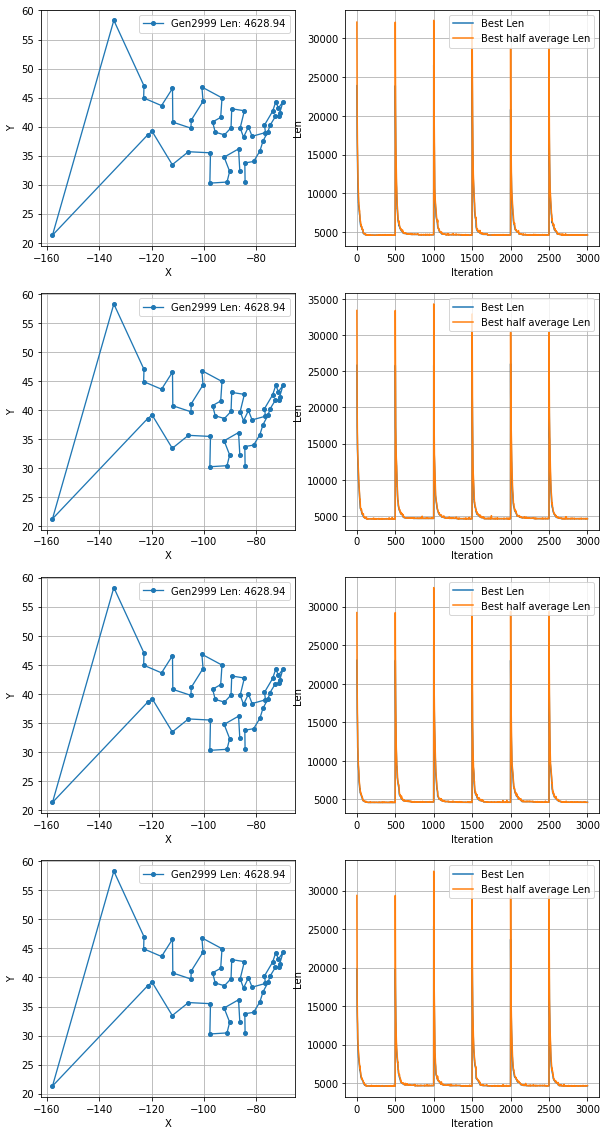

In [51]:
X,Y = np.loadtxt("data02/American_capitals/Region.dat",  usecols=(0,1), delimiter=' ', unpack='true')

filenames=[]
N=(X.size)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(10, 20))
fig.suptitle('')
    
Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data02/American_capitals/0/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/American_capitals/0/Bests.dat",)
M=len(Best)-1

for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax1.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid(True)
ax1.legend()


ax2.plot(np.arange(M+1), Len,label='Best Len')
ax2.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Len')
ax2.grid(True)
ax2.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data02/American_capitals/1/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/American_capitals/1/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax3.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.grid(True)
ax3.legend()


ax4.plot(np.arange(M+1), Len,label='Best Len')
ax4.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Len')
ax4.grid(True)
ax4.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data02/American_capitals/2/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/American_capitals/2/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax5.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.grid(True)
ax5.legend()


ax6.plot(np.arange(M+1), Len,label='Best Len')
ax6.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax6.set_xlabel('Iteration')
ax6.set_ylabel('Len')
ax6.grid(True)
ax6.legend()

Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data02/American_capitals/3/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/American_capitals/3/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax7.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax7.set_xlabel('X')
ax7.set_ylabel('Y')
ax7.grid(True)
ax7.legend()


ax8.plot(np.arange(M+1), Len,label='Best Len')
ax8.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax8.set_xlabel('Iteration')
ax8.set_ylabel('Len')
ax8.grid(True)
ax8.legend()


plt.show()

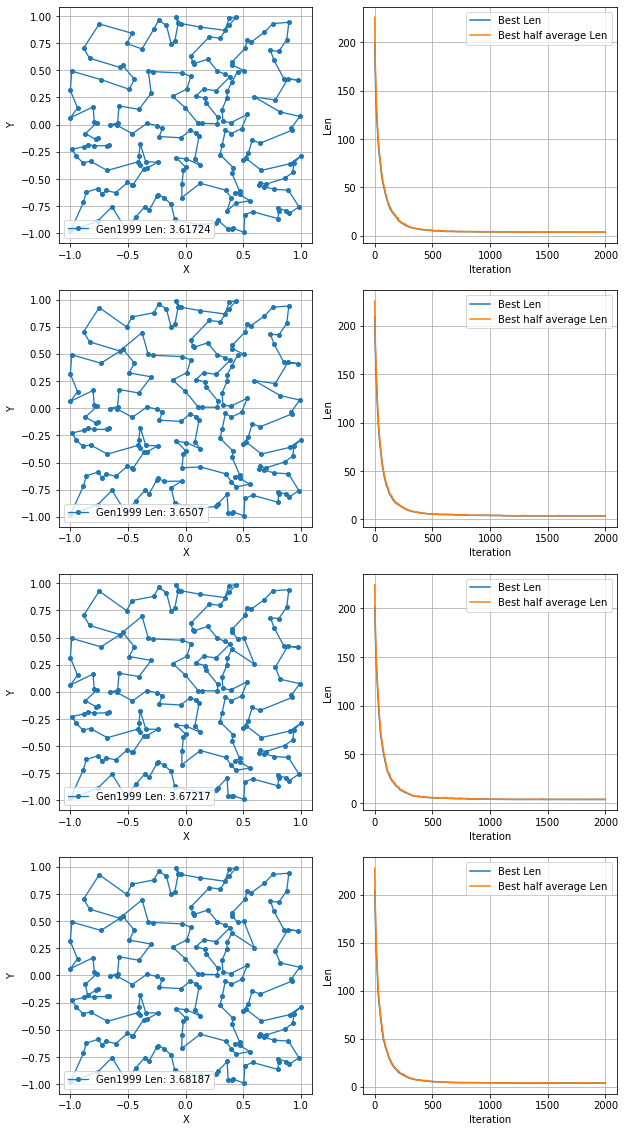

In [24]:
X,Y = np.loadtxt("data03/Region/Region.dat",  usecols=(0,1), delimiter=' ', unpack='true')

filenames=[]
N=(X.size)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(10, 20))
fig.suptitle('')
    
Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data03/Region/0/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data03/Region/0/Bests.dat",)
M=len(Best)-1

for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax1.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid(True)
ax1.legend()


ax2.plot(np.arange(M+1), Len,label='Best Len')
ax2.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Len')
ax2.grid(True)
ax2.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data03/Region/1/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data03/Region/1/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax3.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.grid(True)
ax3.legend()


ax4.plot(np.arange(M+1), Len,label='Best Len')
ax4.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Len')
ax4.grid(True)
ax4.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data03/Region/2/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data03/Region/2/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax5.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.grid(True)
ax5.legend()


ax6.plot(np.arange(M+1), Len,label='Best Len')
ax6.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax6.set_xlabel('Iteration')
ax6.set_ylabel('Len')
ax6.grid(True)
ax6.legend()

Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data03/Region/3/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data03/Region/3/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax7.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax7.set_xlabel('X')
ax7.set_ylabel('Y')
ax7.grid(True)
ax7.legend()


ax8.plot(np.arange(M+1), Len,label='Best Len')
ax8.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax8.set_xlabel('Iteration')
ax8.set_ylabel('Len')
ax8.grid(True)
ax8.legend()


plt.show()

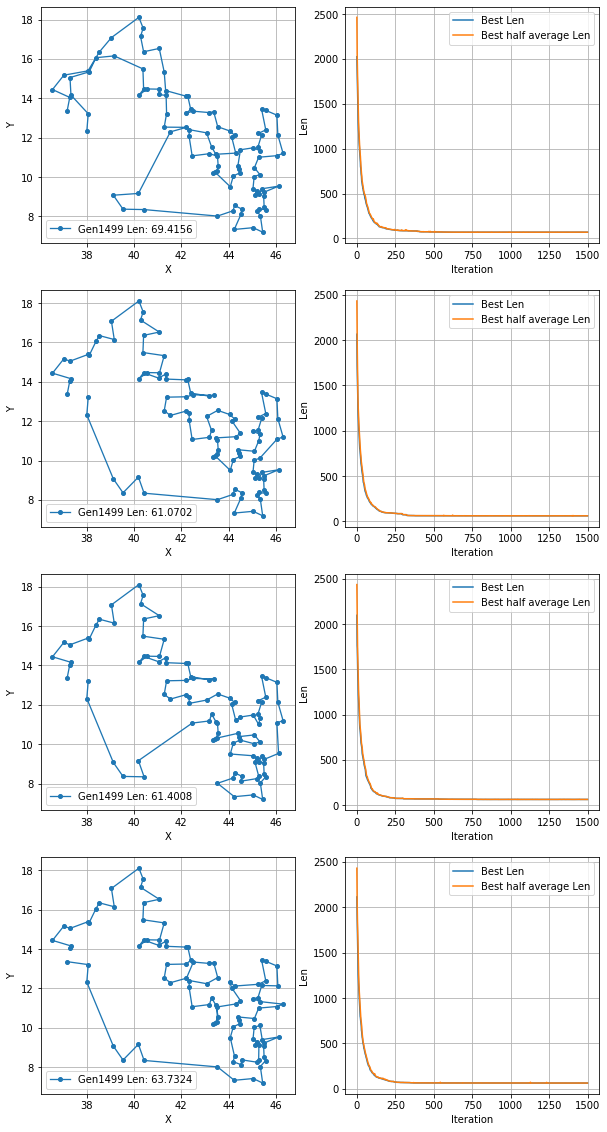

In [52]:
X,Y = np.loadtxt("data01/Capoluoghi/Region.dat",  usecols=(0,1), delimiter=' ', unpack='true')

filenames=[]
N=(X.size)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(10, 20))
fig.suptitle('')
    
Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data01/Capoluoghi/0/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/Capoluoghi/0/Bests.dat",)
M=len(Best)-1

for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax1.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid(True)
ax1.legend()


ax2.plot(np.arange(M+1), Len,label='Best Len')
ax2.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Len')
ax2.grid(True)
ax2.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data01/Capoluoghi/1/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/Capoluoghi/1/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax3.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.grid(True)
ax3.legend()


ax4.plot(np.arange(M+1), Len,label='Best Len')
ax4.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Len')
ax4.grid(True)
ax4.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data01/Capoluoghi/2/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/Capoluoghi/2/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax5.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.grid(True)
ax5.legend()


ax6.plot(np.arange(M+1), Len,label='Best Len')
ax6.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax6.set_xlabel('Iteration')
ax6.set_ylabel('Len')
ax6.grid(True)
ax6.legend()

Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data01/Capoluoghi/3/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data01/Capoluoghi/3/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax7.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax7.set_xlabel('X')
ax7.set_ylabel('Y')
ax7.grid(True)
ax7.legend()


ax8.plot(np.arange(M+1), Len,label='Best Len')
ax8.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax8.set_xlabel('Iteration')
ax8.set_ylabel('Len')
ax8.grid(True)
ax8.legend()


plt.show()

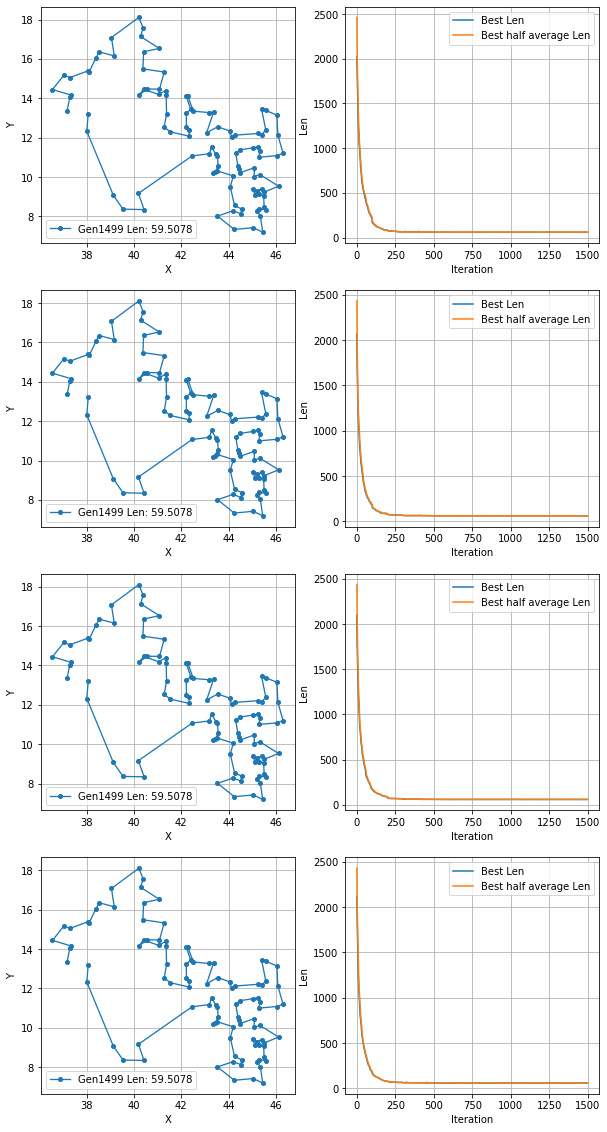

In [56]:
X,Y = np.loadtxt("data02/Capoluoghi/Region.dat",  usecols=(0,1), delimiter=' ', unpack='true')

filenames=[]
N=(X.size)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(10, 20))
fig.suptitle('')
    
Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data02/Capoluoghi/0/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/Capoluoghi/0/Bests.dat",)
M=len(Best)-1

for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax1.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid(True)
ax1.legend()


ax2.plot(np.arange(M+1), Len,label='Best Len')
ax2.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Len')
ax2.grid(True)
ax2.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data02/Capoluoghi/1/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/Capoluoghi/1/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax3.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.grid(True)
ax3.legend()


ax4.plot(np.arange(M+1), Len,label='Best Len')
ax4.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Len')
ax4.grid(True)
ax4.legend()


Xord=[]
Yord=[]

Len, LenAVG = np.loadtxt("data02/Capoluoghi/2/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/Capoluoghi/2/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax5.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.grid(True)
ax5.legend()


ax6.plot(np.arange(M+1), Len,label='Best Len')
ax6.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax6.set_xlabel('Iteration')
ax6.set_ylabel('Len')
ax6.grid(True)
ax6.legend()

Xord=[]
Yord=[]
Len, LenAVG = np.loadtxt("data02/Capoluoghi/3/Bests.dat",  usecols=(X.size,X.size+1), delimiter=' ', unpack='true')
Best = np.loadtxt("data02/Capoluoghi/3/Bests.dat",)
for i in range(X.size):
    Xord.append(X[int(Best[M][i])])
    Yord.append(Y[int(Best[M][i])])


ax7.plot(Xord,Yord,marker="o",markersize=4,lw=1.3, label="Gen"+str(M)+" Len: "+str(Best[M][N]))  
ax7.set_xlabel('X')
ax7.set_ylabel('Y')
ax7.grid(True)
ax7.legend()


ax8.plot(np.arange(M+1), Len,label='Best Len')
ax8.plot(np.arange(M+1), LenAVG, label='Best half average Len')
ax8.set_xlabel('Iteration')
ax8.set_ylabel('Len')
ax8.grid(True)
ax8.legend()


plt.show()